In [1]:
!nvidia-smi
%matplotlib inline

Fri Jul 11 09:26:43 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.57.01              Driver Version: 565.57.01      CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA H100                    On  |   00000000:06:00.0 Off |                    0 |
| N/A   32C    P0             66W /  700W |       1MiB /  95830MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [1]:
import dspy
import pandas as pd
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from tqdm import tqdm
from typing import List, Literal
from dspy.evaluate import Evaluate
from dspy import LabeledFewShot
from dspy.teleprompt import BootstrapFewShotWithRandomSearch
import numpy as np
%matplotlib inline

In [5]:
def obtain_results_without(input_csv, filter_set):
    result_df = pd.read_csv(input_csv)
    result_df = result_df[result_df['direct_source']!=filter_set]
    print(classification_report(result_df["gold_judgment"], result_df['model_pred']))

    judgment_gold = result_df['gold_judgment'].tolist()
    judgment_model = result_df["model_pred"].tolist()
    binary_labels = ['underspecified', 'fully specified']

    cm = confusion_matrix(judgment_gold, judgment_model, labels=binary_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=binary_labels)

    disp.plot(cmap='Blues')  # 可以调整 colormap

In [4]:
# For Snellius
input_csv = "../data/few_shots.csv"
df_few_shots = pd.read_csv(input_csv)
real_csv = "../data/Test_1155.csv"
df_test_1155 = pd.read_csv(real_csv)
learning_csv = "../data/in-context_learning_set.csv"
df_in_context_learning = pd.read_csv(learning_csv)
learning_A_csv = "../data/learning_version_A.csv"
df_in_context_learning_A = pd.read_csv(learning_A_csv)
learning_B_csv = "../data/learning_version_B.csv"
df_in_context_learning_B = pd.read_csv(learning_B_csv)

In [ ]:
"""
module load CUDA/12.4.0
source ~/sglang-venv-2/bin/activate
huggingface-cli login


# 创建所有必要的目录
mkdir -p /scratch-local/yhuang/sglang_cache
mkdir -p /scratch-local/yhuang/huggingface_cache
mkdir -p /scratch-local/yhuang/torch_cache
mkdir -p /scratch-local/yhuang/cuda_cache
mkdir -p /scratch-local/yhuang/xdg_cache
mkdir -p /scratch-local/yhuang/tmp
mkdir -p /scratch-local/yhuang/logs

# 设置所有相关环境变量
export SGLANG_CACHE_DIR=/scratch-local/yhuang/sglang_cache
export TRANSFORMERS_CACHE=/scratch-local/yhuang/huggingface_cache
export HF_HOME=/scratch-local/yhuang/huggingface_cache
export HF_DATASETS_CACHE=/scratch-local/yhuang/huggingface_cache/datasets
export TORCH_HOME=/scratch-local/yhuang/torch_cache
export CUDA_CACHE_PATH=/scratch-local/yhuang/cuda_cache
export XDG_CACHE_HOME=/scratch-local/yhuang/xdg_cache
export TMPDIR=/scratch-local/yhuang/tmp
export TEMP=/scratch-local/yhuang/tmp
export TMP=/scratch-local/yhuang/tmp
export SGLANG_LOG_DIR=/scratch-local/yhuang/logs

# launching
python -m sglang.launch_server --port 7501 --model-path Qwen/Qwen3-4B --trust-remote-code
CUDA_VISIBLE_DEVICES=0,1 python -m sglang.launch_server --port 7501 --model-path Qwen/Qwen3-32B --trust-remote-code --tp 2
"""

# Helper functions

In [5]:
def dspy_cot_no_theory_B(lm, input_list, class_to_use):

    judgment_list = []
    reasoning_list = []

    dspy.configure(lm=lm)
    classification = class_to_use

    for item in tqdm(input_list, desc="Processing: "):
        try:
          result = classification(query = item)
          judgment_list.append(result.judgment)
          reasoning_list.append(result.reasoning)
        except Exception as e:
          print(f'Error processing item: {item}')
          print(f'Error message: {e}')
          judgment_list.append("error")
          reasoning_list.append("error")

    return judgment_list, reasoning_list

def dspy_predict_no_theory_B(lm, input_list, class_to_use):
    judgment_list = []

    dspy.configure(lm=lm)
    classification = class_to_use

    for item in tqdm(input_list, desc="Processing: "):
        try:
          result = classification(query = item)
          judgment_list.append(result.judgment)
        except Exception as e:
          print(f'Error processing item: {item}')
          print(f'Error message: {e}')
          judgment_list.append("error")

    return judgment_list

def collect_thinking(loaded_model):
  history_data = loaded_model.history
  think_list = []
  print(f'The current length of history is {len(history_data)}.')

  for record in history_data:
      thinking = record['outputs'][0].split("[[ ## reasoning ## ]]")[0]
      think_list.append(thinking)

  return think_list

# In-context learning data loading and preprocessing
def load_data_no_theory_B(csv_path):
    """Load CSV data and convert to DSPy examples"""
    df = pd.read_csv(csv_path)

    examples = []
    for _, row in df.iterrows():
        if pd.notna(row['request']) and pd.notna(row['gold_judgment']):
            example = dspy.Example(
                query=row['request'],
                judgment=row['gold_judgment']
            ).with_inputs('request')  # Only request is input
            examples.append(example)

    return examples


def run_experiment_B(test_df, model_in_use, program_in_use, think_file_name, input_col='request', mode='CoT'):
  requests_to_test = test_df[input_col].tolist()

  if mode == 'CoT':
    judgment_list, reasoning_list = dspy_cot_no_theory_B(model_in_use, requests_to_test, program_in_use)
    df = test_df.copy()
    df['model_pred'] = judgment_list
    df['reasoning'] = reasoning_list
    think_list = collect_thinking(model_in_use)
    print(f"The number of thinking pieces is {len(think_list)}.")
    think_df = pd.DataFrame(think_list)
    think_df.to_csv(f'{think_file_name}.csv')
  else:
    judgment_list = dspy_predict_no_theory_B(model_in_use, requests_to_test, program_in_use)
    df = test_df.copy()
    df['model_pred'] = judgment_list
    think_list = collect_thinking(model_in_use)
    print(f"The number of thinking pieces is {len(think_list)}.")
    think_df = pd.DataFrame(think_list)
    think_df.to_csv(f'{think_file_name}.csv')

  return df

def retrieve_results(result_df, output_name):
  judgment_list = result_df['model_pred'].tolist()

  if 'error' in judgment_list:
    print("There are errors in model predictions. The CSV file is saved but requires manual inspection.")
    result_df.to_csv(f'{output_name}_error.csv')
  else:
    print("No error is detected, proceed to evaluations.")
    print(classification_report(result_df['gold_judgment'], result_df['model_pred']))
    result_df.to_csv(f'{output_name}.csv')

  judgment_gold = result_df['gold_judgment'].tolist()
  judgment_model= result_df['model_pred'].tolist()

  binary_labels = ['underspecified', 'fully specified']

  cm = confusion_matrix(judgment_gold, judgment_model, labels=binary_labels)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=binary_labels)

  disp.plot(cmap='Blues')  # 可以调整 colormap

In [6]:
def dspy_cot_no_theory_A(lm, input_list, class_to_use):

    judgment_list = []
    reasoning_list = []

    dspy.configure(lm=lm)
    classification = class_to_use

    for item in tqdm(input_list, desc="Processing: "):
        try:
          result = classification(request = item)
          judgment_list.append(result.judgment)
          reasoning_list.append(result.reasoning)
        except Exception as e:
          print(f'Error processing item: {item}')
          print(f'Error message: {e}')
          judgment_list.append("error")
          reasoning_list.append("error")

    return judgment_list, reasoning_list

def dspy_predict_no_theory_A(lm, input_list, class_to_use):
    judgment_list = []

    dspy.configure(lm=lm)
    classification = class_to_use

    for item in tqdm(input_list, desc="Processing: "):
        try:
          result = classification(request = item)
          judgment_list.append(result.judgment)
        except Exception as e:
          print(f'Error processing item: {item}')
          print(f'Error message: {e}')
          judgment_list.append("error")

    return judgment_list


# In-context learning data loading and preprocessing
def load_data_no_theory_A(csv_path):
    """Load CSV data and convert to DSPy examples"""
    df = pd.read_csv(csv_path)

    examples = []
    for _, row in df.iterrows():
        if pd.notna(row['request']) and pd.notna(row['gold_judgment']):
            example = dspy.Example(
                request=row['request'],
                judgment=row['gold_judgment']
            ).with_inputs('request')  # Only request is input
            examples.append(example)

    return examples

def run_experiment_A(test_df, model_in_use, program_in_use, think_file_name, input_col='request', mode='CoT'):
  requests_to_test = test_df[input_col].tolist()

  if mode == 'CoT':
    judgment_list, reasoning_list = dspy_cot_no_theory_A(model_in_use, requests_to_test, program_in_use)
    df = test_df.copy()
    df['model_pred'] = judgment_list
    df['reasoning'] = reasoning_list
    think_list = collect_thinking(model_in_use)
    print(f"The number of thinking pieces is {len(think_list)}.")
    think_df = pd.DataFrame(think_list)
    think_df.to_csv(f'{think_file_name}.csv')
  else:
    judgment_list = dspy_predict_no_theory_A(model_in_use, requests_to_test, program_in_use)
    df = test_df.copy()
    df['model_pred'] = judgment_list
    think_list = collect_thinking(model_in_use)
    print(f"The number of thinking pieces is {len(think_list)}.")
    think_df = pd.DataFrame(think_list)
    think_df.to_csv(f'{think_file_name}.csv')

  return df

--------------------------------------------------------------------------------------------------

# Controlled Experiments

## Qwen3-4B DSPy CoT CONTROL W2
Done => DSPy_FS_UND_ICL.csv

                 precision    recall  f1-score   support

fully specified       0.61      0.88      0.72       598
 underspecified       0.76      0.40      0.53       557

       accuracy                           0.65      1155
      macro avg       0.69      0.64      0.62      1155
   weighted avg       0.69      0.65      0.63      1155



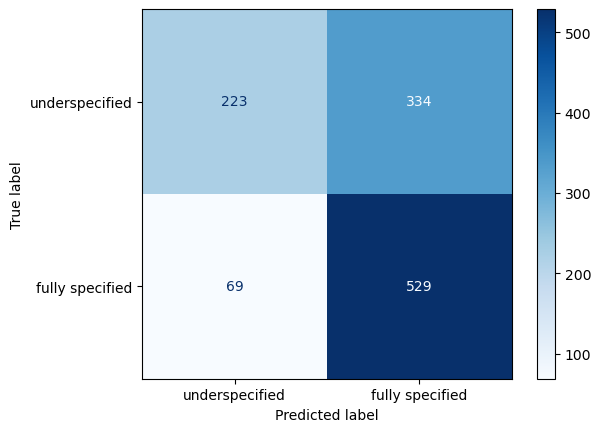

In [6]:
result_df = pd.read_csv('../clean_exp_2/DSPy_FS_UND_ICL.csv')
print(classification_report(result_df['gold_judgment'], result_df['model_pred']))
judgment_gold = result_df['gold_judgment'].tolist()
judgment_model= result_df['model_pred'].tolist()

binary_labels = ['underspecified', 'fully specified']

cm = confusion_matrix(judgment_gold, judgment_model, labels=binary_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=binary_labels)

disp.plot(cmap='Blues')  # 可以调整 colormap

                 precision    recall  f1-score   support

fully specified       0.63      0.87      0.73       431
 underspecified       0.79      0.49      0.60       424

       accuracy                           0.68       855
      macro avg       0.71      0.68      0.67       855
   weighted avg       0.71      0.68      0.67       855



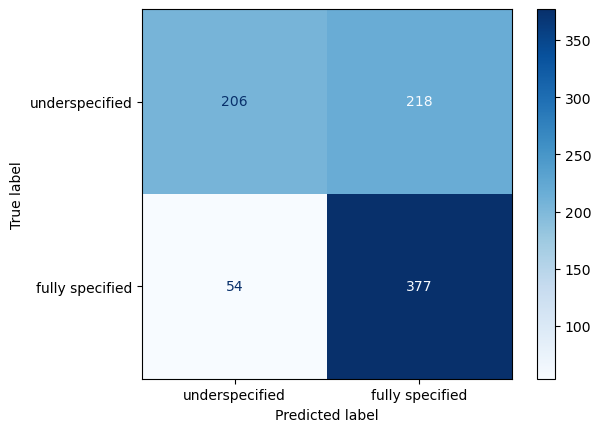

In [7]:
obtain_results_without('../clean_exp_2/DSPy_FS_UND_ICL.csv', 'AmbigQA')

## Qwen3-4B DSPy Predict CONTROL W2

In [ ]:
# Restart the model to clean the cache
model = dspy.LM("openai/Qwen/Qwen3-4B",
                 api_base="http://localhost:7501/v1",
                 api_key="whatever", model_type='chat', cache=False)

dspy.configure(lm=model)

In [ ]:
class Classification_no_theory(dspy.Signature):
  query: str = dspy.InputField(desc="An input user query.")
  judgment: Literal['underspecified', 'fully specified'] = dspy.OutputField()

# Load your in-context learning set
examples = load_data_no_theory_B(learning_csv)
print(f"Loaded {len(examples)} samples from in-context learning set")

optimizer = dspy.LabeledFewShot(k=150)

# Compiling
program = dspy.Predict(Classification_no_theory)
compiled_program = optimizer.compile(program, trainset=examples)


# One-shot Testing
result = compiled_program(query="Who is the president?")
print(result)

Loaded 150 samples from in-context learning set
Prediction(
    judgment='underspecified'
)


In [ ]:
dspy.inspect_history()





[2025-07-10T02:20:27.493419]

System message:

Your input fields are:
1. `query` (str): An input user query.

Your output fields are:
1. `judgment` (Literal['underspecified', 'fully specified'])

All interactions will be structured in the following way, with the appropriate values filled in.

[[ ## query ## ]]
{query}

[[ ## judgment ## ]]
{judgment}        # note: the value you produce must exactly match (no extra characters) one of: underspecified; fully specified

[[ ## completed ## ]]

In adhering to this structure, your objective is: 
        Given the fields `query`, produce the fields `judgment`.


User message:

[[ ## query ## ]]
What's the latitude range where Oarcinidae is found?

Respond with the corresponding output fields, starting with the field `[[ ## judgment ## ]]` (must be formatted as a valid Python Literal['underspecified', 'fully specified']), and then ending with the marker for `[[ ## completed ## ]]`.


Assistant message:

[[ ## judgment ## ]]
underspecified


In [ ]:
experiment_result = run_experiment_B(df_test_1155, model, compiled_program, 'Qwen3_4B_UND_FS_DSPy_Predict_no_theory_examples_wording_B_think_contents', mode="Predict")

Processing: 100%|██████████| 1155/1155 [1:13:23<00:00,  3.81s/it]

The current length of history is 1167.
The number of thinking pieces is 1167.


No error is detected, proceed to evaluations.
                 precision    recall  f1-score   support

fully specified       0.61      0.88      0.72       598
 underspecified       0.76      0.40      0.53       557

       accuracy                           0.65      1155
      macro avg       0.68      0.64      0.62      1155
   weighted avg       0.68      0.65      0.63      1155



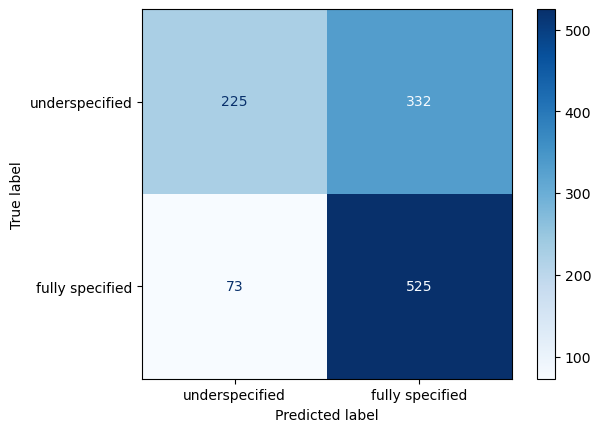

In [ ]:
retrieve_results(experiment_result, 'Qwen3_4B_UND_FS_DSPy_Predict_no_theory_examples_wording_B')

                 precision    recall  f1-score   support

fully specified       0.63      0.86      0.73       431
 underspecified       0.77      0.50      0.60       424

       accuracy                           0.68       855
      macro avg       0.70      0.68      0.67       855
   weighted avg       0.70      0.68      0.67       855



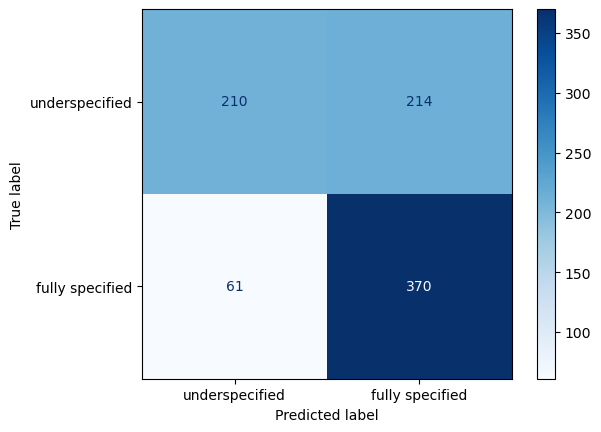

In [ ]:
obtain_results_without('Qwen3_4B_UND_FS_DSPy_Predict_no_theory_examples_wording_B.csv', 'AmbigQA')

## Qwen3-4B DSPy CoT CONTROL W1

In [26]:
# Restart the model to clean the cache
model = dspy.LM("openai/Qwen/Qwen3-4B",
                 api_base="http://localhost:7501/v1",
                 api_key="whatever", model_type='chat', cache=False)

dspy.configure(lm=model)

In [27]:
# wording A variant
class Classification_no_theory(dspy.Signature):
  request: str = dspy.InputField(desc="An input user question/request.")
  judgment: Literal['underspecified', 'fully specified'] = dspy.OutputField()

# Load your in-context learning set
examples = load_data_no_theory_A(learning_csv)
print(f"Loaded {len(examples)} samples from in-context learning set")

optimizer = dspy.LabeledFewShot(k=150)

# Compiling
program = dspy.ChainOfThought(Classification_no_theory)
compiled_program = optimizer.compile(program, trainset=examples)


# One-shot Testing
result = compiled_program(request="Who is the president?")
print(result)

Loaded 150 samples from in-context learning set
Prediction(
    reasoning='The request is ambiguous as it does not specify which country\'s president is being asked. The term "president" can refer to different countries (e.g., United States, France, China, etc.), and without additional context, the question cannot be fully resolved.',
    judgment='underspecified'
)


In [28]:
dspy.inspect_history()





[2025-07-11T00:10:57.367081]

System message:

Your input fields are:
1. `request` (str): An input user question/request.

Your output fields are:
1. `reasoning` (str)
2. `judgment` (Literal['underspecified', 'fully specified'])

All interactions will be structured in the following way, with the appropriate values filled in.

[[ ## request ## ]]
{request}

[[ ## reasoning ## ]]
{reasoning}

[[ ## judgment ## ]]
{judgment}        # note: the value you produce must exactly match (no extra characters) one of: underspecified; fully specified

[[ ## completed ## ]]

In adhering to this structure, your objective is: 
        Given the fields `request`, produce the fields `judgment`.


User message:

This is an example of the task, though some input or output fields are not supplied.

[[ ## request ## ]]
What's the latitude range where Oarcinidae is found?

Respond with the corresponding output fields, starting with the field `[[ ## reasoning ## ]]`, then `[[ ## judgment ## ]]` (must be f

In [29]:
experiment_result = run_experiment_A(df_test_1155, model, compiled_program, 'Qwen3_4B_UND_FS_DSPy_CoT_no_theory_examples_wording_A_think_contents')

Processing: 100%|██████████| 1155/1155 [1:27:28<00:00,  4.54s/it]

The current length of history is 1167.
The number of thinking pieces is 1167.


No error is detected, proceed to evaluations.
                 precision    recall  f1-score   support

fully specified       0.60      0.86      0.71       598
 underspecified       0.72      0.38      0.50       557

       accuracy                           0.63      1155
      macro avg       0.66      0.62      0.60      1155
   weighted avg       0.66      0.63      0.61      1155



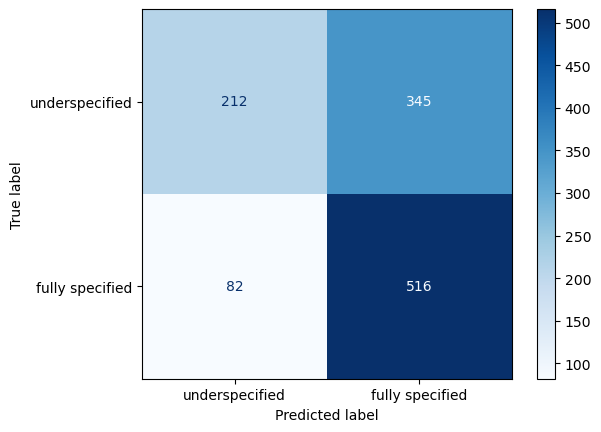

In [32]:
retrieve_results(experiment_result, 'Qwen3_4B_UND_FS_DSPy_CoT_no_theory_examples_wording_A')

                 precision    recall  f1-score   support

fully specified       0.62      0.85      0.72       431
 underspecified       0.76      0.46      0.57       424

       accuracy                           0.66       855
      macro avg       0.69      0.66      0.65       855
   weighted avg       0.69      0.66      0.65       855



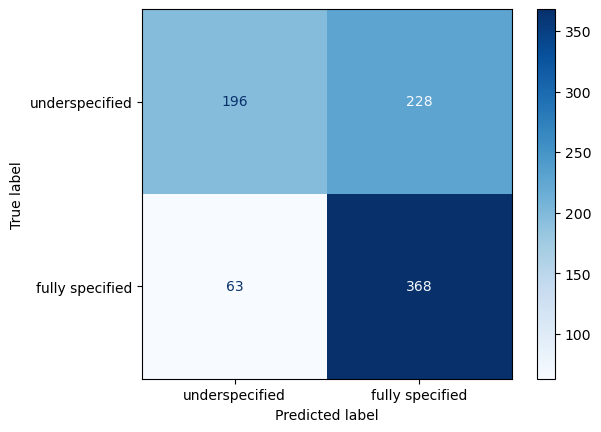

In [33]:
obtain_results_without('Qwen3_4B_UND_FS_DSPy_CoT_no_theory_examples_wording_A.csv', 'AmbigQA')

## Qwen3-4B DSPy Predict CONTROL W1

In [34]:
# Restart the model to clean the cache
model = dspy.LM("openai/Qwen/Qwen3-4B",
                 api_base="http://localhost:7501/v1",
                 api_key="whatever", model_type='chat', cache=False)

dspy.configure(lm=model)

In [35]:
# wording A variant
class Classification_no_theory(dspy.Signature):
  request: str = dspy.InputField(desc="An input user question/request.")
  judgment: Literal['underspecified', 'fully specified'] = dspy.OutputField()

# Load your in-context learning set
examples = load_data_no_theory_A(learning_csv)
print(f"Loaded {len(examples)} samples from in-context learning set")

optimizer = dspy.LabeledFewShot(k=150)

# Compiling
program = dspy.Predict(Classification_no_theory)
compiled_program = optimizer.compile(program, trainset=examples)


# One-shot Testing
result = compiled_program(request="Who is the president?")
print(result)

Loaded 150 samples from in-context learning set
Prediction(
    judgment='underspecified'
)


In [36]:
dspy.inspect_history()





[2025-07-11T01:40:14.345380]

System message:

Your input fields are:
1. `request` (str): An input user question/request.

Your output fields are:
1. `judgment` (Literal['underspecified', 'fully specified'])

All interactions will be structured in the following way, with the appropriate values filled in.

[[ ## request ## ]]
{request}

[[ ## judgment ## ]]
{judgment}        # note: the value you produce must exactly match (no extra characters) one of: underspecified; fully specified

[[ ## completed ## ]]

In adhering to this structure, your objective is: 
        Given the fields `request`, produce the fields `judgment`.


User message:

[[ ## request ## ]]
What's the latitude range where Oarcinidae is found?

Respond with the corresponding output fields, starting with the field `[[ ## judgment ## ]]` (must be formatted as a valid Python Literal['underspecified', 'fully specified']), and then ending with the marker for `[[ ## completed ## ]]`.


Assistant message:

[[ ## judgment 

In [37]:
experiment_result = run_experiment_A(df_test_1155, model, compiled_program, 'Qwen3_4B_UND_FS_DSPy_Predict_no_theory_examples_wording_A_think_contents', mode="Predict")

Processing: 100%|██████████| 1155/1155 [1:10:46<00:00,  3.68s/it]

The current length of history is 1162.
The number of thinking pieces is 1162.


No error is detected, proceed to evaluations.
                 precision    recall  f1-score   support

fully specified       0.62      0.89      0.73       598
 underspecified       0.77      0.41      0.54       557

       accuracy                           0.66      1155
      macro avg       0.70      0.65      0.63      1155
   weighted avg       0.69      0.66      0.64      1155



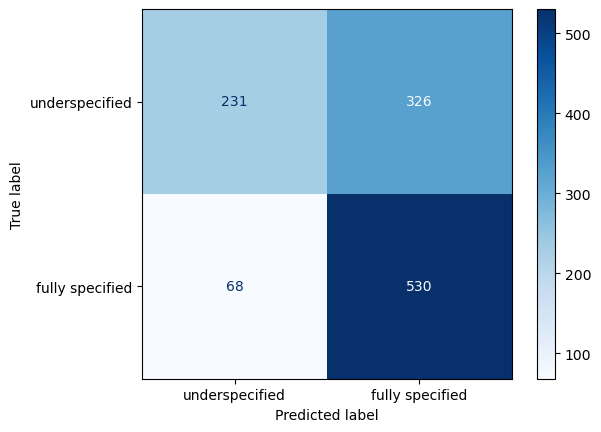

In [38]:
retrieve_results(experiment_result, 'Qwen3_4B_UND_FS_DSPy_Predict_no_theory_examples_wording_A')

                 precision    recall  f1-score   support

fully specified       0.65      0.88      0.74       431
 underspecified       0.80      0.51      0.62       424

       accuracy                           0.69       855
      macro avg       0.72      0.69      0.68       855
   weighted avg       0.72      0.69      0.68       855



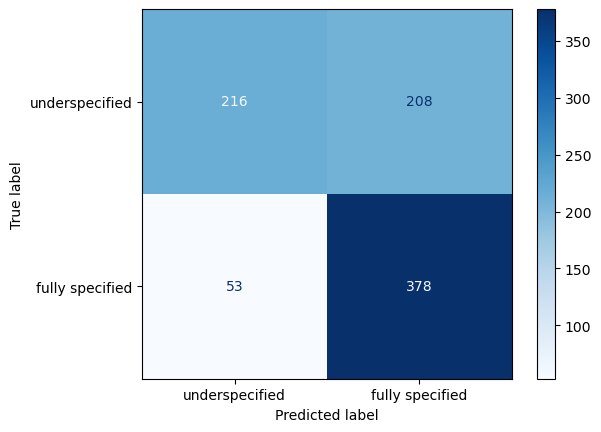

In [39]:
obtain_results_without('Qwen3_4B_UND_FS_DSPy_Predict_no_theory_examples_wording_A.csv', 'AmbigQA')